# Acoustic Experiments

## Imports

In [39]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz
from scipy.signal import argrelextrema
from scipy.signal import argrelmax

Populating the interactive namespace from numpy and matplotlib


## Constants & Global Variables

In [40]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.1
tone_frequency = 15000
tone_frequency_bandwidth = 100
tone_period = 1/tone_frequency

scaler = None

def normalize(data):
    return data/0x7FFF

## Tone Generation

In [41]:
def generate_tone(frequency, duration, sample_rate):
    tone_data = np.sin(2 * math.pi * np.arange(math.ceil(sample_rate * duration)) * frequency / sample_rate) * 0x7FFF
    return tone_data

def get_tone_period(data, frequency):
    return tone_data[0:math.ceil(1/frequency*sample_rate)+1].squeeze()

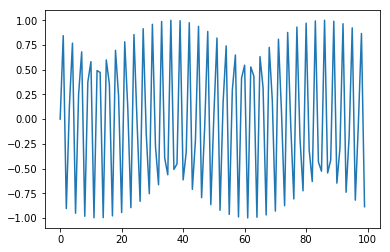

In [42]:
tone_data = generate_tone(tone_frequency, tone_duration, sample_rate)
# tone_data = scaler.fit_transform(np.reshape(tone_data,(tone_data.size,1)))
wavfile.write(input_data_directory+"/audio/tone.wav", sample_rate, tone_data.astype(np.int16))

tone_data = normalize(tone_data)
plt.figure()
plt.plot(tone_data[0:100])

## Load Sample Audio

### Filter Helper Function

In [43]:
# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=5):
    nyq = 0.5 * fs
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, fs, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=order)
    return lfilter(b, a, data)    

### Visualize possible filters

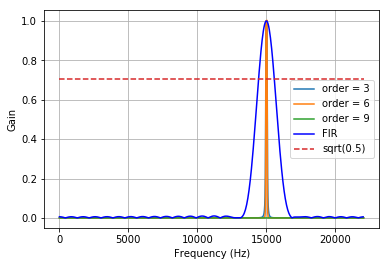

In [44]:
# Plot the frequency response for a few different filters and parameters.
plt.figure()
plt.clf()

low_cut_frequency = tone_frequency - tone_frequency_bandwidth/2
high_cut_frequency = tone_frequency + tone_frequency_bandwidth/2

for order in [3, 6, 9]:
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 50
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")

plt.plot([0, 0.5 * sample_rate], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [45]:
def load_sample(path, scaler=None):
    sample_rate, sample_data = wavfile.read(path)
    if scaler is None:
        return sample_rate, normalize(sample_data)
    else:
        return sample_rate, np.array(scaler.fit_transform(np.reshape(sample_data,(sample_data.size,1))).squeeze())
       
def tone_filter(sample_data, tone_frequency, tone_frequency_bandwidth, tone_data, scaler=None, butler_order=6):
    filtered_sample_data = butter_bandpass_filter(sample_data,
                                                  tone_frequency-tone_frequency_bandwidth/2,
                                                  tone_frequency+tone_frequency_bandwidth/2,
                                                  sample_rate,
                                                  order=butler_order)
    correlation = sp.correlate(filtered_sample_data, tone_data, 'valid')
    absolute_correlation = np.absolute(correlation)
    return absolute_correlation

def tone_recognition(sample_data, sample_rate, duration):
    last_index = 0
    tones = []
    tone_candidates = argrelmax(sample_data, order=math.ceil(duration*sample_rate*2))[0]
    for candidate in tone_candidates:
        tones.append((candidate, sample_data[candidate]))
    tones.sort(key=lambda tup: tup[1])
    tones.reverse()
    
    return tones

def compute_etoa(tones, sample_rate):
    if len(tones) < 2:
        raise NameError("Insufficient Tones Detected")
    else:
        return abs(tones[0][0]-tones[1][0])/sample_rate
    
def compute_distance(etoa_a, etoa_b, d_aa, d_bb, c=340.29):
    return (c/2) * (etoa_a - etoa_b) + (d_aa + d_bb)

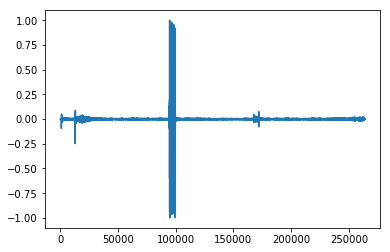

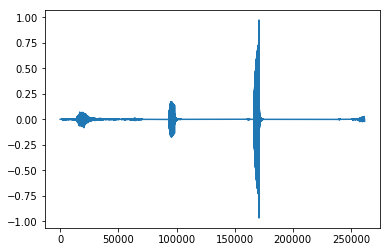

In [46]:
device_a_sample_rate, device_a_sample_data = load_sample(input_data_directory+"/audio/trial1-0.5mda.wav",
                                                         scaler)
plt.figure()
plt.plot(device_a_sample_data)

device_b_sample_rate, device_b_sample_data = load_sample(input_data_directory+"/audio/trial1-0.5mdb.wav",
                                                         scaler)
plt.figure()
plt.plot(device_b_sample_data)

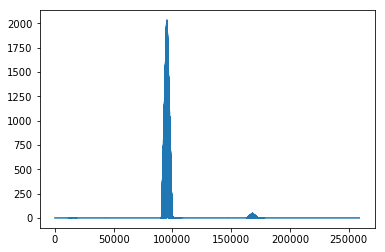

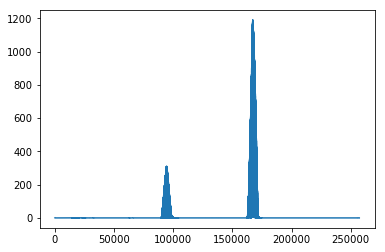

In [47]:
device_a_correlation = tone_filter(device_a_sample_data,
                                   tone_frequency,
                                   tone_frequency_bandwidth,
                                   tone_data,
                                   scaler)
plt.figure()
plt.plot(device_a_correlation)

device_b_correlation = tone_filter(device_b_sample_data,
                                   tone_frequency,
                                   tone_frequency_bandwidth,
                                   tone_data,
                                   scaler)
plt.figure()
plt.plot(device_b_correlation)

In [51]:
device_a_tones = tone_recognition(device_a_correlation, sample_rate, tone_duration)
print("Device A")
for tone in device_a_tones:
    print("Sample:",tone[0],"Value:",tone[1])        
print("A total of",len(device_a_tones),"tones were detected.")

print("Device B")
device_b_tones = tone_recognition(device_b_correlation, sample_rate, tone_duration)
for tone in device_b_tones:
    print("Sample:",tone[0],"Value:",tone[1])
print("A total of",len(device_b_tones),"tones were detected.")

Device A
Sample: 95346 Value: 2030.77054474
Sample: 168225 Value: 46.0410365913
Sample: 12309 Value: 0.0961924181781
Sample: 129474 Value: 0.0492876389573
Sample: 48924 Value: 0.0472335277955
Sample: 153090 Value: 0.0432432903141
Sample: 37502 Value: 0.0398585625579
Sample: 244390 Value: 0.0342884756322
Sample: 75221 Value: 0.0317814734553
Sample: 256853 Value: 0.0301889855641
Sample: 222400 Value: 0.0292452844421
Sample: 201222 Value: 0.0285760472792
A total of 12 tones were detected.
Device B
Sample: 167246 Value: 1188.4849099
Sample: 94419 Value: 309.174152868
Sample: 14785 Value: 0.33287266086
Sample: 61804 Value: 0.0478133171947
Sample: 256539 Value: 0.0356441630163
Sample: 43176 Value: 0.0234998536682
Sample: 150229 Value: 0.0229529966987
Sample: 207150 Value: 0.0186578348822
Sample: 196285 Value: 0.01744183529
Sample: 137489 Value: 0.0173775909364
Sample: 80819 Value: 0.015786781294
Sample: 227320 Value: 0.0133133121221
Sample: 239928 Value: 0.0112740535672
A total of 13 tones w

In [52]:
device_a_etoa = compute_etoa(device_a_tones, sample_rate)
print("Device A ETOA:",device_a_etoa)

device_b_etoa = compute_etoa(device_b_tones, sample_rate)
print("Device B ETOA:",device_b_etoa)

Device A ETOA: 1.65258503401
Device B ETOA: 1.65140589569


In [53]:
distance = compute_distance(device_a_etoa, device_b_etoa, 0.04, 0.04)
distance

0.28062448979591659